In [4]:
from sklearn.datasets import fetch_openml

# MNIST 데이터 다운로드
mnist = fetch_openml("mnist_784", version=1, data_home=".")


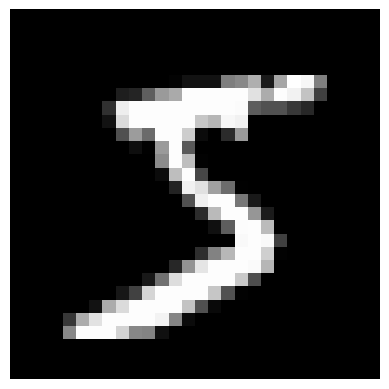

이 이미지의 데이터의 레이블은 5이다


In [18]:
# 데이터 전처리
X = mnist.data / 255.0  # 0 ~ 255 값을 [0,1] 구간으로 정규화
y = mnist.target.astype(int)  # 레이블 데이터를 정수형으로 변환

# 첫 번째 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline

# iloc를 사용하여 첫 번째 행 데이터에 접근
plt.imshow(X.iloc[0].values.reshape(28, 28), cmap="gray")
plt.axis('off')  # 축을 숨기기
plt.show()  # 플롯 표시

print("이 이미지의 데이터의 레이블은 {}이다".format(y.iloc[0]))

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 스플릿
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

# 2.2 데이터를 파이토치 텐서로 변환
X_train = torch.tensor(X_train.values, dtype=torch.float32)  # Pandas DataFrame에서 Tensor로 변환
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)  # LongTensor로 변환
y_test = torch.tensor(y_test.values, dtype=torch.long)

# 2.3 데이터와 라벨을 하나로 묶어 DataSet으로 만듬
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 미니배치 크기를 지정해 DataLoader 객체로 변환
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

# 데이터 확인 (첫 번째 배치)
X_batch, y_batch = next(iter(loader_train))
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

X_batch shape: torch.Size([64, 784])
y_batch shape: torch.Size([64])


In [29]:
# 3. 신경망 구성 (케라스 스타일)
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [30]:
# 4. 오차함수 및 최적화 기법 설정
from torch import optim

# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()
# criterion을 변수명으로 사용하는 경우가 많음

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [37]:
# 5. 학습 및 추론 설정
# 5-1. 학습 중 1 에포크에서 수행할 일을 함수로 정의
# Pytorch에서는 Chainer의 training.Trainer()에 해당하는 것이 없음

def train(epoch):
    model.train() # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, target in loader_train :
        optimizer.zero_grad() # 경사를 0으로 초기화
        outputs = model(data) # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, target) # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward() # 오차를 역전파 계산
        optimizer.step() # 역전파 계산한 값으로 가중치를 수정
    print("epoch{} : 완료\n".format(epoch))

In [38]:
# 5-2. 추론 1 에포크에서 할 일을 함수로 정의
# Pytorch에서는 Chainer의 trainer.extend(extensions.Evaluator())에 해당하는 것이 없음

def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에서는 미분이 필요 없음
        for data, targets in loader_test:
            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.view_as(predicted)).sum().item()
            # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print("\n테스트 데이터에서 예측 정확도 : {}/{} ({:.0f}%)\n".format(
        correct, data_num, 100. * correct / data_num))


In [39]:
# 학습 전 상태에서 테스트 데이터로 정확도 측정
test()


테스트 데이터에서 예측 정확도 : 1071/10000 (11%)



In [1]:
# 6. 학습 및 추론 수행
for epoch in range(3) :
    train(epoch)

test()

NameError: name 'train' is not defined

예측 결과 : 4


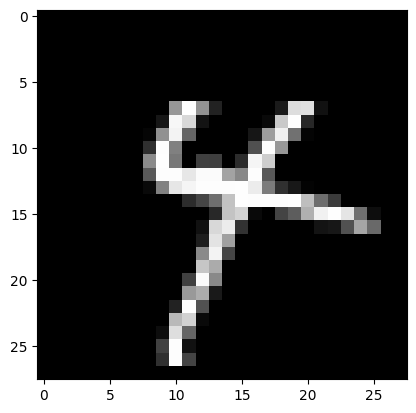

이 이미지 데이터 정답 레이블 4입니다


In [47]:
# 2024번째 데이터를 예로 추론 수행

index = 2024

model.eval() # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data) # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0) # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap = 'gray')
plt.show()
print("이 이미지 데이터 정답 레이블 {:.0f}입니다".format(y_test[index]))

In [48]:
# 3. 신경망 구성
# 신경망 구성(체이너 스타일)
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid) #체어나와 달리 None을 받을 수는 없음
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        # 입력 x에 따라 forward 계산 과정이 변화함
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

model = Net(n_in=28*28*1, n_mid = 100, n_out = 10) # 신경망 객체 생성
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
